<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Overview</a></span></li></ul></li><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Create-a-DD-SIMCA-Model" data-toc-modified-id="Create-a-DD-SIMCA-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create a DD-SIMCA Model</a></span><ul class="toc-item"><li><span><a href="#A-Simple-Model" data-toc-modified-id="A-Simple-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A Simple Model</a></span></li><li><span><a href="#An-Optimized-Pipeline" data-toc-modified-id="An-Optimized-Pipeline-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>An Optimized Pipeline</a></span></li></ul></li><li><span><a href="#Create-an-Explainer" data-toc-modified-id="Create-an-Explainer-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create an Explainer</a></span></li><li><span><a href="#A-Manual-Improvement" data-toc-modified-id="A-Manual-Improvement-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A Manual Improvement</a></span></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/chemometrics.git
    !cd chemometrics; pip install -r requirements.txt
else:
    import sys
    sys.path.append('../../')

import chemometrics

import matplotlib.pyplot as plt
%matplotlib notebook

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

import shap
shap.initjs()

In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [ ]:
import bokeh
from bokeh.plotting import output_notebook
from chemometrics.utils import bokeh_color_spectrum
from chemometrics.utils import color_spectrum
output_notebook()

Overview
-------------
This notebook demonstrates the use of SHAP to explain model predictions.

For "soft" models / OCC, we need to look at the likelihood a sample is assigned as an inlier or not; when models combine many of these (PLS-DA, SIMCA_Classifier) we need to pull those apart to inspect each known class.  Typically, a model may be trained and TEFF optimized.  From this, optimal hyperparameters can be extracted then individual models retrained and examined to explain predictions. 

In [3]:
%watermark -t -m -v --iversions

pandas    0.25.1
watermark 2.0.2
numpy     1.21.4
shap      0.37.0
sklearn   0.22.2.post1
16:05:39 

CPython 3.7.4
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-167-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


# Load the Data

In [4]:
# Let's load some data from the tests/ for this example
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/chemometrics/master/tests/data/simca_train.csv'
else:
    loc = '../tests/data/simca_train.csv'
df = pd.read_csv(loc)

In [5]:
# You can see that samples are rows, columns are different features
df.head()

,Group,Class,Name,3999,3991,3983,3975,3967,3959,3951,...,527,519,511,503,495,487,479,471,463,455
0,1,Pure,F 16 08 001 D,-0.968873,-0.969487,-0.970409,-0.969794,-0.970101,-0.971944,-0.970409,...,2.629155,2.652808,2.665095,2.684140,2.700114,2.693664,2.721617,2.728067,2.718238,2.668986
1,1,Pure,F 16 08 002 D,-0.965465,-0.964848,-0.965465,-0.966697,-0.966389,-0.968238,-0.968546,...,2.669310,2.672083,2.703205,2.711524,2.749117,2.733402,2.765756,2.758977,2.775000,2.714092
2,1,Pure,F 16 08 003 D,-0.968031,-0.969617,-0.968665,-0.970568,-0.970568,-0.970568,-0.971203,...,2.538191,2.525503,2.544218,2.570861,2.570544,2.567690,2.566421,2.566739,2.547390,2.592536
3,1,Pure,F 16 08 005 D,-0.957622,-0.957622,-0.958654,-0.958654,-0.960374,-0.959686,-0.957622,...,2.626278,2.622494,2.646919,2.666528,2.685448,2.685792,2.708497,2.693705,2.689920,2.707809
4,1,Pure,F 16 08 006 D,-0.960211,-0.961166,-0.961166,-0.961803,-0.961803,-0.962758,-0.963713,...,2.698431,2.711802,2.710846,2.746185,2.777385,2.767516,2.800307,2.807311,2.764331,2.773564


In [7]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Class'].values, dtype=str) # Take the class as the target

X_train = raw_x

# Create a DD-SIMCA Model

In [8]:
from chemometrics.classifier.simca import DDSIMCA_Model
from chemometrics.preprocessing.scaling import CorrectedScaler
from chemometrics.preprocessing.filter import SavGol

## A Simple Model

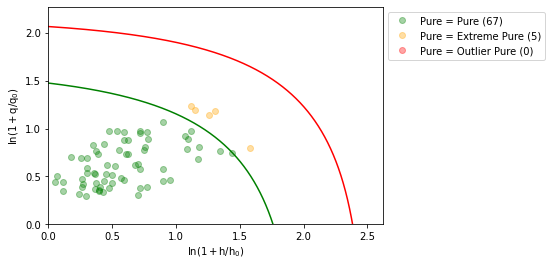

In [9]:
# Here the data is spectra so we will not scale the X data
model = DDSIMCA_Model(n_components=7, alpha=0.05, gamma=0.01, scale_x=False)
_ = model.fit(X_train, raw_y)
_ = model.visualize(X_train, raw_y)

In [10]:
mask1 = model.predict_proba(X_train)[:,0] > 0.5
mask2 = model.predict(X_train)
np.all(mask1 == mask2)

True

In [11]:
model.predict(X_train)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [12]:
model.score(X_train, np.array([True]*len(X_train)))

0.9305555555555556

## An Optimized Pipeline

In [13]:
import imblearn

# Let's use some Pareto scaling just as an illustration, even though this may not be ideal with spectral data
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", 
     CorrectedScaler(
        with_mean=True, 
        with_std=True, 
        pareto=True, 
        biased=False
     )
    ),
    ("savgol",
     SavGol(
         window_length=11, 
         deriv=2, 
         polyorder=3
     )
    ),
    ("simca", 
     DDSIMCA_Model(
         n_components=7, 
         alpha=0.05, 
         scale_x=False
     )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'scaling__pareto': [True, False],
    'savgol__window_length': [5, 13],
    'savgol__deriv': [0, 1, 2],
    'savgol__polyorder': [3],
    'simca__n_components': np.arange(1, 10),
}]

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = model.fit(
    X_train, 
    np.array([True]*len(X_train))
)

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be importe

In [14]:
model.best_params_

{'savgol__deriv': 0,
 'savgol__polyorder': 3,
 'savgol__window_length': 5,
 'scaling__pareto': False,
 'simca__n_components': 1}

In [15]:
# model.cv_results_ # View full CV results

In [16]:
model.predict_proba(X_train)[:10]

array([[0.76695424, 0.23304576],
       [0.8525092 , 0.1474908 ],
       [0.59213484, 0.40786516],
       [0.78321397, 0.21678603],
       [0.86245726, 0.13754274],
       [0.85291238, 0.14708762],
       [0.63829246, 0.36170754],
       [0.52757239, 0.47242761],
       [0.81877868, 0.18122132],
       [0.84973995, 0.15026005]])

# Create an Explainer

In [38]:
# If you have a small dataset with only a few features you can use the entire training dataset for 
# the background (data). In problems with more features you probably want to pass only the median 
# of the training dataset, or weighted k-medians.
# See https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html
# Since we have some spectral data with > 400 features, we can just use a random subsample  of 10 as the background.

# See SHAP documentation for a discussion on the utility and impact of using a "squashing function" to 
# go from an unbounded "margin space" (raw model output) to a bounded probability space.
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Squashing%20Effect.html#Probability-space-explaination
explainer = shap.KernelExplainer(
    model = model.predict_proba, # Use probability function to "squash"
    data = shap.sample(X_train, 10, random_state=0), 
)

In [39]:
# If there are many features to explain, this can fail to converge. You can choose to look at just
# the top features as shown below.  Feature correlation can also be a concern.  Using a smaller subset
# of decorrelated inputs

shap_values = explainer.shap_values(X_train, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_train.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )

In [40]:
explainer.expected_value 

array([0.76685307, 0.23314693])

In [46]:
np.mean(model.predict_proba(X_train)[:,0]) 
# If the background sampling was bad, the mean model prediction will differ greatly from the explainer.expected_value.
# Here, they are both about 75% so this is probably reasonable

0.7562148769295564

In [47]:
shap.force_plot(
    base_value=explainer.expected_value[0], # [0] to look at inlier probability
    shap_values=shap_values[0], # [0] to look at inlier probability
    features=X_train, # Feature values for visualization
    feature_names=['Channel {}'.format(i) for i in range(X_train.shape[1])] # Feature names for visualization
)

In [50]:
# Look at the lowest probability example
look_at = np.argmin(model.predict_proba(X_train)[:,0]) 

shap.force_plot(
    base_value=explainer.expected_value[0], # [0] to look at inlier probability
    shap_values=shap_values[0][look_at,:], # [0] to look at inlier probability
    features=raw_x[look_at,:], # Feature values for visualization
    feature_names=['Channel {}'.format(i) for i in range(X_train.shape[1])] # Feature names for visualization
)

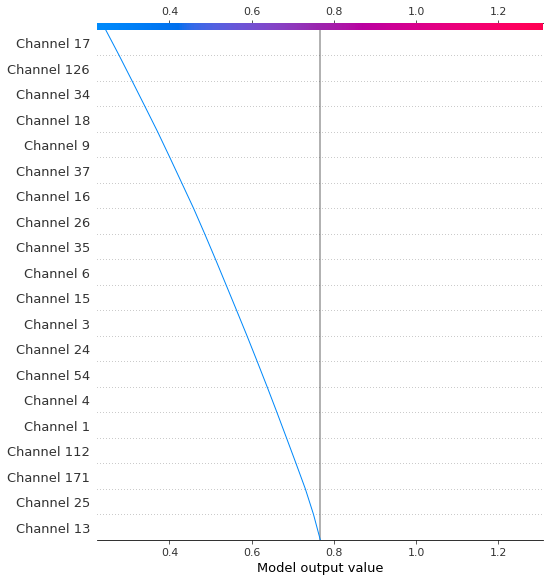

In [51]:
shap.decision_plot(
    explainer.expected_value[0], 
    shap_values[0][look_at,:],
    feature_names=['Channel {}'.format(i) for i in range(raw_x.shape[1])]
)

Text(0.5, 1.0, 'Worst Example')

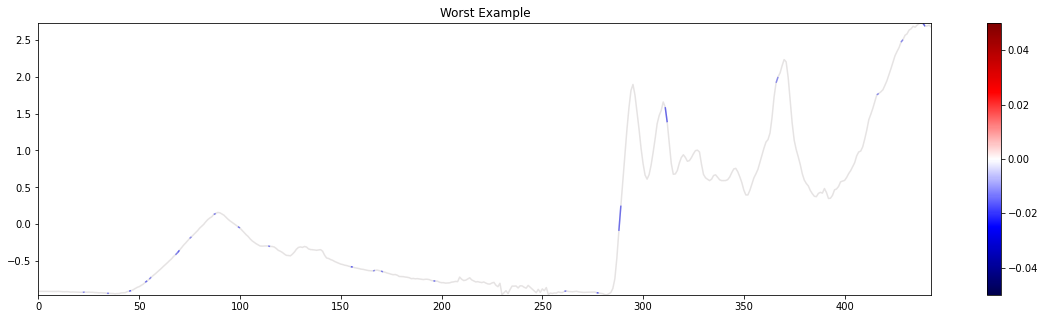

In [210]:
ax = color_spectrum(
    y=X_train[look_at,:], 
    x=np.arange(X_train.shape[1]),
    importance_values=shap_values[0][look_at], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Worst Example')

# So the spectrum that is most strongly predicted to be an outlier, even though it is NOT is due mostly to
# parts of the spectrum that are at low wavenumbers are likely not relevant. This may not be a good 
# model. In part, this could be due to the fact that those values are poorly sampled/measured so in practice
# you might consider getting rid of that part of the spectrum before fitting. The model have learned something
# you didn't want it to!

Text(0.5, 1.0, 'Best Example')

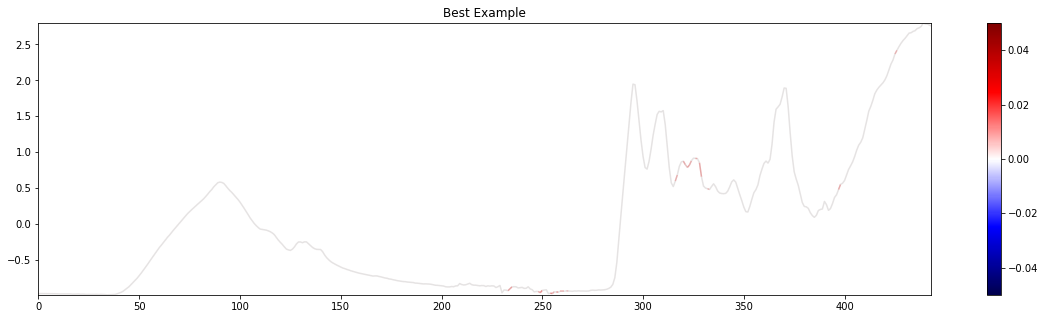

In [87]:
best = np.argmax(model.predict_proba(X_train)[:,0])
ax = color_spectrum(
    X=X_train[best,:], 
    importance_values=shap_values[0][best], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Best Example')

# The features that are signalling this spectrum is part of the training class look like they are from 
# reasonable parts of the spectrum.

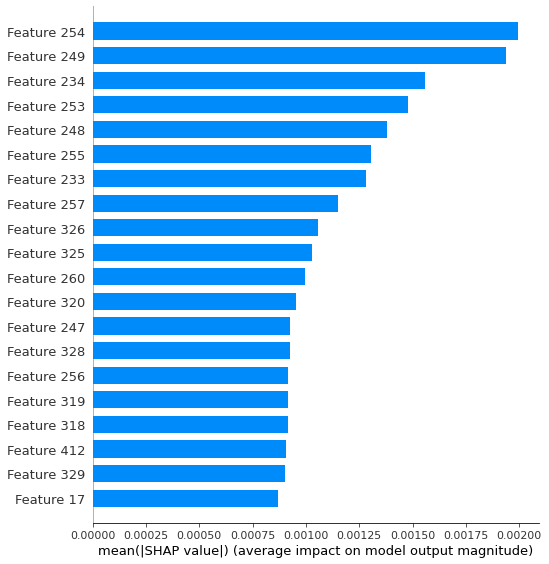

In [85]:
# On AVERAGE, it looks like the most important parts of the spectrum are somewhere around the ~250 and ~325
# channels in this spectrum which seems consistent with the above example.
shap.summary_plot(
    shap_values=shap_values[0],
    features=X_train,
    plot_type='bar'
)

# A Manual Improvement

In [91]:
# Let's just choose to trim off the initial part of the spectrum
X_refined = X_train[:, 50:]

In [92]:
# Also, let's fix the number of components to a larger number
import imblearn

# Let's use some Pareto scaling just as an illustration, even though this may not be ideal with spectral data
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("scaling", 
     CorrectedScaler(
        with_mean=True, 
        with_std=True, 
        pareto=True, 
        biased=False
     )
    ),
    ("savgol",
     SavGol(
         window_length=11, 
         deriv=2, 
         polyorder=3
     )
    ),
    ("simca", 
     DDSIMCA_Model(
         n_components=7, 
         alpha=0.05, 
         scale_x=False
     )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'scaling__pareto': [True, False],
    'savgol__window_length': [5, 13],
    'savgol__deriv': [0, 1, 2],
    'savgol__polyorder': [3],
    'simca__n_components': [7], 
}]

model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = model.fit(
    X_refined, 
    np.array([True]*len(X_refined))
)

In [104]:
model.best_params_

{'savgol__deriv': 0,
 'savgol__polyorder': 3,
 'savgol__window_length': 13,
 'scaling__pareto': True,
 'simca__n_components': 7}

In [93]:
explainer = shap.KernelExplainer(
    model = model.predict_proba, # Use probability function to "squash"
    data = shap.sample(X_refined, 10, random_state=0), 
)

In [96]:
explainer.expected_value

array([0.68407793, 0.31592207])

In [95]:
np.mean(model.predict_proba(X_refined)[:,0]) 

0.7481697001065348

In [97]:
shap_values = explainer.shap_values(X_refined, 
                                    nsamples='auto', # Can increase for lower variance
                                    l1_reg='num_features({})'.format(
                                        np.min(
                                            [X_refined.shape[1], 20] # Only look at (up to) the top 20 features
                                        )
                                    )
                                   )

Text(0.5, 1.0, 'Worst Example')

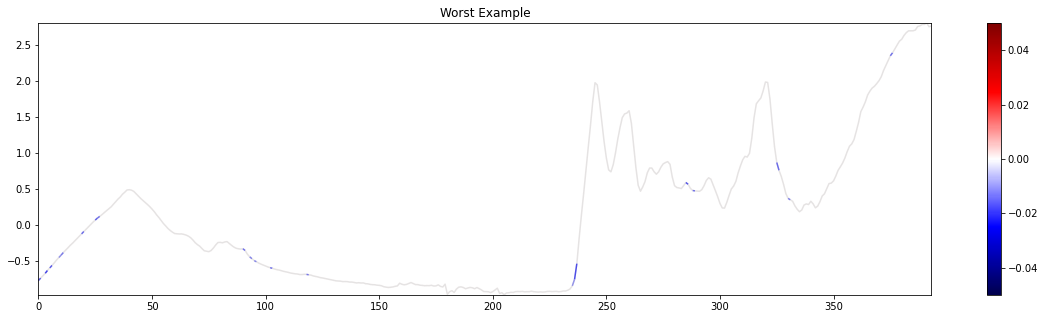

In [100]:
worst = np.argmin(model.predict_proba(X_refined)[:,0])

ax = color_spectrum(
    X=X_refined[worst,:], 
    importance_values=shap_values[0][worst], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Worst Example')

Text(0.5, 1.0, 'Best Example')

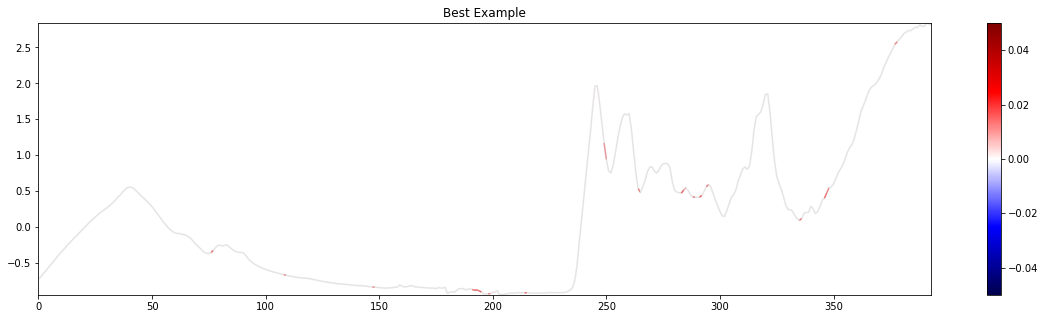

In [101]:
best = np.argmax(model.predict_proba(X_refined)[:,0])

ax = color_spectrum(
    X=X_refined[best,:], 
    importance_values=shap_values[0][best], 
    figsize=(20,5),
    cmap='seismic',
    bounds=(-0.05, 0.05),
    background=True
)
ax.set_title('Best Example')

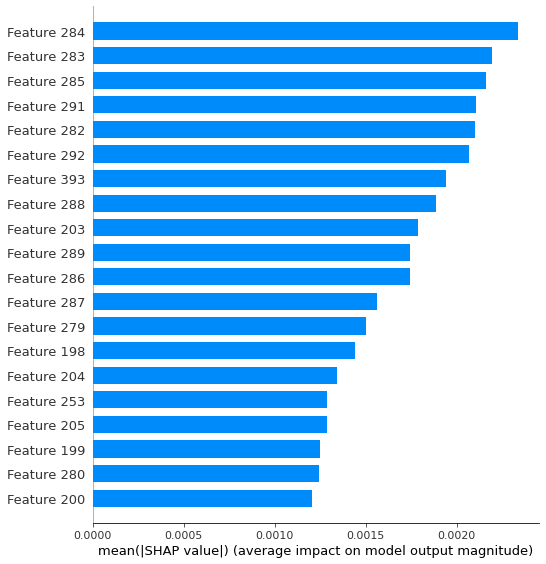

In [103]:
# On AVERAGE, it looks like the most important parts of the spectrum are somewhere around the ~250 and ~325
# channels in this spectrum which seems consistent with the above example.
shap.summary_plot(
    shap_values=shap_values[0],
    features=X_refined,
    plot_type='bar'
)

In [213]:
chosen = 0
bokeh_color_spectrum(x=np.arange(X_refined.shape[1]), 
                     y=X_refined[chosen, :], 
                     importance_values=shap_values[0][chosen])

In [ ]:
# 1. bokeh interactive coloring
# 2. SHAP for SITE example
# 3. Also do for test data
# 4. Manifold Elliptic explane
# 5. example of PLS-DA where you have to take it apart and analyze IN/OUT for each class

In [ ]:
# EllipticManifold 

In [ ]:
# Even if SIMCA, etc. models make multiple assignments, it is useulf to inspet EACH individual model
# to understand why each prediciton is made, since they are independent

In [ ]:
# For discriminant methods like PLS-DA it is a little more challenging to explain